In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
%cd ..
%cd ..

/home/daniel/Documents/attention_equivariant/equivariant-attention/notebooks
/home/daniel/Documents/attention_equivariant/equivariant-attention


In [2]:
from models import translation_attention, positional_encodings, vanilla_attention
import jax
from jax import numpy as jnp, random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib import colormaps

rngs = random.split(random.PRNGKey(seed=123), 10)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
def get_training_data(rng, n_samples, d, f):
    X_train = random.normal(rng, shape=[n_samples, d])
    X_train = X_train / jnp.linalg.norm(X_train, axis=-1)[:, None]
    Y_train = jax.vmap(f)(X_train)

    return X_train, Y_train

def augment(data):
  return jnp.concatenate([jnp.roll(data, i) for i in range(d)], axis = 0)
def check_equivariance(params, n_samples):
  normalized_params = params / jnp.linalg.norm(params, axis=-1)[:, None]
  return jnp.mean(jnp.sum(jnp.square(normalized_params[:n_samples] - jnp.roll(normalized_params[n_samples: 2 * n_samples], -1)), -1))

d = 10
n_samples = 50

f = lambda x : 2 * x + 1 + jnp.roll(x, 1)
X_train, Y_train = get_training_data(rngs[0], n_samples, d, f)
X_test, Y_test = get_training_data(rngs[1], n_samples, d, f)
X_train_aug, Y_train_aug = augment(X_train), augment(Y_train)

In [42]:
vanilla_keys = X_train_aug + (random.normal(key=rngs[2], shape=Y_train_aug.shape) * 0.3)
vanilla_values = Y_train_aug + (random.normal(key=rngs[3], shape=Y_train_aug.shape) * 0.3)
vanilla_beta = jnp.array(5.)
lr = 1.0

n_epochs = 1_000
n_loss_measurements = 100
vanilla_train_loss = []
vanilla_test_loss = []
equivariant_keys_loss = []
equivariant_values_loss = []

for e in tqdm(range(n_epochs)):
  vanilla_keys, vanilla_values, vanilla_beta = vanilla_attention.update([vanilla_keys, vanilla_values, vanilla_beta], X_train_aug, Y_train_aug, lr)
  if e % int(n_epochs / n_loss_measurements) == 0:
    vanilla_train_loss.append(vanilla_attention.loss([vanilla_keys, vanilla_values, vanilla_beta], X_train_aug, Y_train_aug))
    vanilla_test_loss.append(vanilla_attention.loss([vanilla_keys, vanilla_values, vanilla_beta], X_test, Y_test))
    equivariant_keys_loss.append(check_equivariance(vanilla_keys, n_samples))
    equivariant_values_loss.append(check_equivariance(vanilla_values, n_samples))

X_test_pred_vanilla = vanilla_attention.batched_call_fn(X_test, keys=vanilla_keys, values=vanilla_values, beta=vanilla_beta)

  0%|          | 0/1000 [00:00<?, ?it/s]

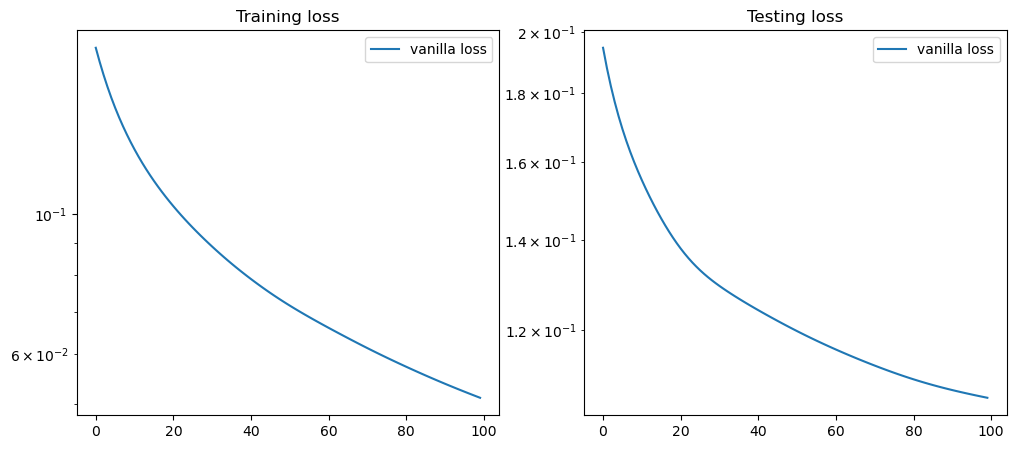

In [43]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(vanilla_train_loss, label = "vanilla loss")
ax[0].set(title = "Training loss", yscale="log")
ax[0].legend()

ax[1].plot(vanilla_test_loss, label = "vanilla loss")
ax[1].set(title = "Testing loss", yscale="log")
ax[1].legend()
# ax.legend()

[Text(0.5, 1.0, 'Values -- Failure to be equivariant'), None]

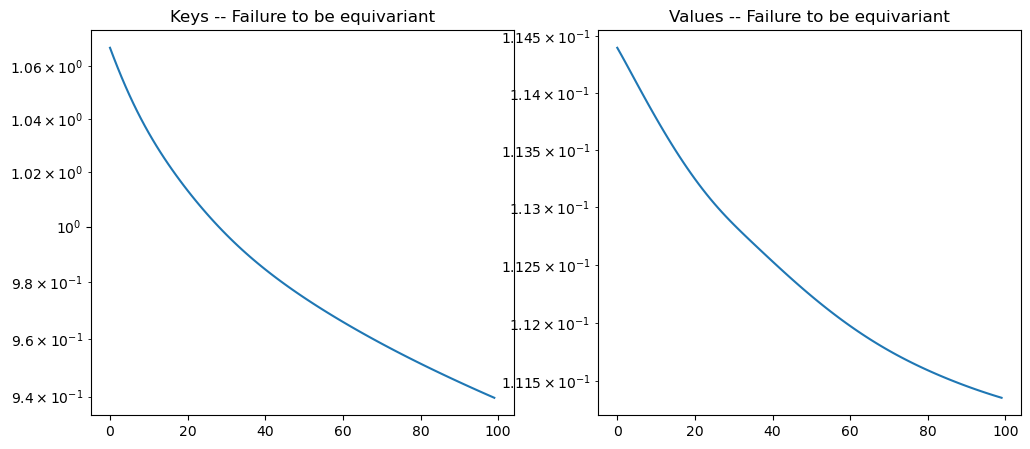

In [44]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(equivariant_keys_loss)
ax[0].set(title = "Keys -- Failure to be equivariant", yscale="log")

ax[1].plot(equivariant_values_loss)
ax[1].set(title = "Values -- Failure to be equivariant", yscale="log")
# ax.legend()

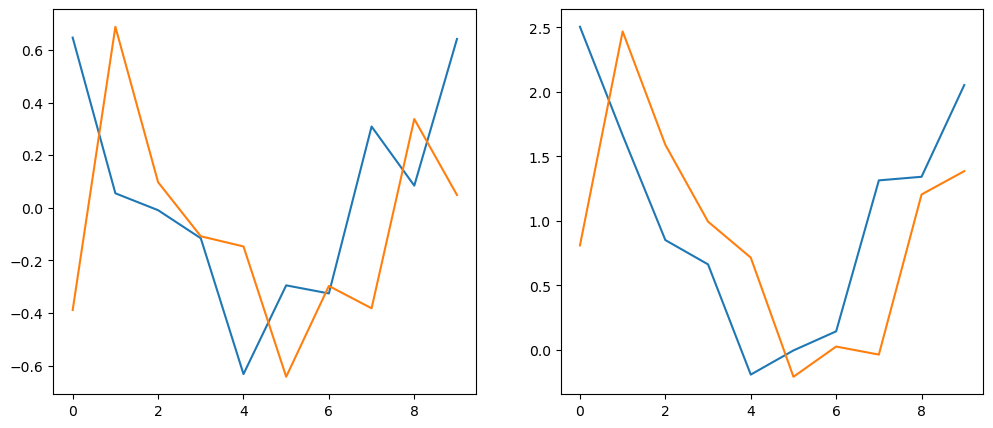

In [18]:
i = 2
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ax[0].plot(vanilla_keys[i])
ax[0].plot(vanilla_keys[i + n_samples])

ax[1].plot(vanilla_values[i])
ax[1].plot(vanilla_values[i + n_samples])

In [114]:
def get_loss(test, pred):
  return jnp.mean(jnp.sum(jnp.square(test - pred), axis = -1))

vanilla_loss = get_loss(X_test_pred_vanilla, Y_test) 
fft_loss = get_loss(X_test_pred_fft, Y_test)

print("vanilla loss", vanilla_loss)
print("fft loss", fft_loss)

vanilla loss 1.2338821
fft loss 0.6104257


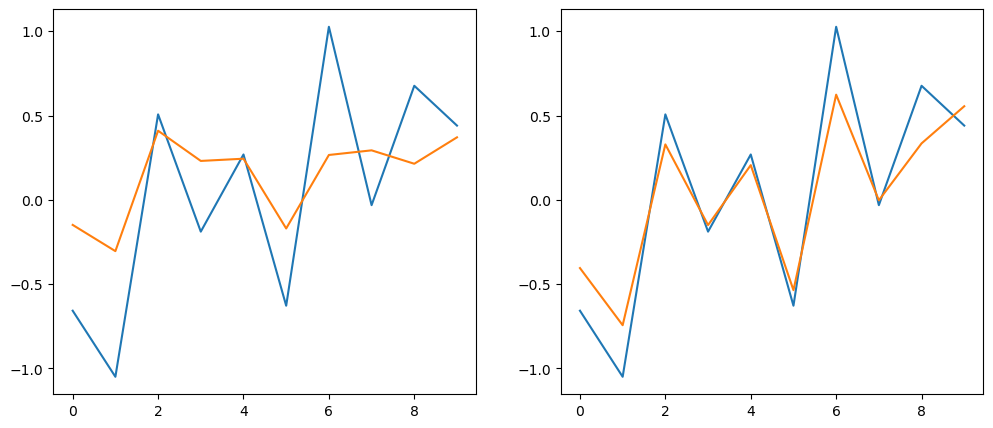

In [115]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

i = 3
ax[0].plot(Y_test[i])
ax[0].plot(X_test_pred_vanilla[i])

ax[1].plot(Y_test[i])
ax[1].plot(X_test_pred_fft[i])